# Setup & Configuration  


Weather Data Functions: For setting up 'get_weather' function, the "requests" library is required. Additionally, in order to generate the returns in readable format, installing tabulate package is required to use the tabulat function. Moreover, to encode the location names, the function "quote" is required.

In [2]:
%pip install tabulate
import requests
from tabulate import tabulate
from urllib.parse import quote

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\waqua\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Natural Language Processing: After 'get_weather' the development moves to natural language processing. Setting up for that requires the function to understand natural language, extract the question and provide responses or error messages. 

In [3]:
%pip install spacy
%pip install dateparser
%pip install geopy
%pip install geonamescache

import spacy
import dateparser
from geopy.geocoders import Nominatim
from datetime import datetime, timedelta
from geonamescache import GeonamesCache
import spacy.cli

# Load spaCy model
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("Downloading spaCy model 'en_core_web_sm'...")
    spacy.cli.download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

# 🔹 Global city database for all world cities
import geonamescache
gc = geonamescache.GeonamesCache()
all_cities = {city['name'].lower(): city['name'] for city in gc.get_cities().values()}


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\waqua\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\waqua\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\waqua\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\waqua\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


The following setup is to use geolocator and matplotlib to create visualizations as outputs for weather related questions. 

In [4]:
geolocator = Nominatim(user_agent="weather_app")
%pip install matplotlib
import matplotlib.pyplot as plt


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\waqua\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


# Weather Data Functions
The purpose of this function is to generate a response containing current weather conditions at a specific city, with a short forecast. The coding was prepared in a way that the get_weather(location, forecast_days) function calls the wttr.in service, parses the JSON response and gives the desired return.   


In [5]:
def _safe_int_conversion(value):
    """
    Safely converts a value to an integer, returning None if conversion fails.
    """
    try:
        return int(float(value)) # Convert to float first to handle decimal strings
    except (ValueError, TypeError):
        return None

def _format_current_weather_table(current_weather: dict) -> str:
    """
    Formats current weather data into a human-readable table.
    """
    headers = ["Metric", "Value"]
    table_data = [
        ["Temperature", f"{current_weather.get('temperature_celsius')}°C"],
        ["Feels Like", f"{current_weather.get('feels_like_celsius')}°C"],
        ["Description", current_weather.get('description')],
        ["Humidity", f"{current_weather.get('humidity_percent')}%"] if current_weather.get('humidity_percent') is not None else ["Humidity", "N/A"],
        ["Wind Speed", f"{current_weather.get('wind_speed_kmph')} km/h"] if current_weather.get('wind_speed_kmph') is not None else ["Wind Speed", "N/A"],
    ]
    return tabulate(table_data, headers=headers, tablefmt="grid")

def _format_forecast_table(forecast_data: list) -> str:
    """
    Formats forecast data into a human-readable table.
    """
    headers = ["Date", "Max Temp (°C)", "Min Temp (°C)", "Humidity (%)", "Wind Speed (km/h)", "Description"]
    table_data = []
    for day in forecast_data:
        table_data.append([
            day.get('date'),
            day.get('maxtemp_celsius'),
            day.get('mintemp_celsius'),
            f"{day.get('humidity_percent')}%" if day.get('humidity_percent') is not None else "N/A",
            f"{day.get('wind_speed_kmph')} km/h" if day.get('wind_speed_kmph') is not None else "N/A",
            day.get('description')
        ])
    return tabulate(table_data, headers=headers, tablefmt="grid")

def get_weather(location: str, forecast_days: int) -> dict:
    """
    Fetches current weather conditions and forecast data for a specified location
    using the wttr.in API.

    Args:
        location (str): The name of the city or location (e.g., "London", "New York").
        forecast_days (int): The number of forecast days to retrieve (1-5).

    Returns:
        dict: A dictionary containing current weather and forecast data formatted as tables,
              or an error message if the request fails or the location is invalid.
    """
    # 1. Input Validation
    if not 1 <= forecast_days <= 5:
        return {"error": "Forecast days must be between 1 and 5."}

    # 2. URL Encoding for Location
    # Encode the location to handle spaces and special characters in the URL.
    encoded_location = quote(location)

    # 3. Constructing the API URL
    # The format=j1 parameter requests JSON output.
    # The num_of_days parameter limits the number of forecast days.
    api_url = f"https://wttr.in/{encoded_location}?format=j1&num_of_days={forecast_days}"

    try:
        # 4. Making the API Request
        response = requests.get(api_url)
        response.raise_for_status()  # Raise an exception for HTTP errors (4xx or 5xx).

        # 5. Parsing the JSON Response
        json_data = response.json()

        # 6. Error Handling for Invalid Location from API
        # wttr.in returns an "error" key if the location is not found.
        if "error" in json_data:
            return {"error": f"Location not found or invalid: {location}"}

        # 7. Extracting Current Weather Conditions
        current_condition_data = json_data.get("current_condition", [{}])[0]
        current_weather = {
            "temperature_celsius": _safe_int_conversion(current_condition_data.get("temp_C")),
            "description": current_condition_data.get("weatherDesc", [{}])[0].get("value") if current_condition_data.get("weatherDesc") else "N/A",
            "feels_like_celsius": _safe_int_conversion(current_condition_data.get("FeelsLikeC")),
            "humidity_percent": _safe_int_conversion(current_condition_data.get("humidity")),
            "wind_speed_kmph": _safe_int_conversion(current_condition_data.get("windspeedKmph")),
        }

        # 8. Extracting Forecast Data
        forecast_data_list = []
        for day_data in json_data.get("weather", [])[:forecast_days]:
            daily_forecast = {
                "date": day_data.get("date"),
                "maxtemp_celsius": _safe_int_conversion(day_data.get("maxtempC")),
                "mintemp_celsius": _safe_int_conversion(day_data.get("mintempC")),
                "humidity_percent": _safe_int_conversion(day_data.get("hourly", [{}])[0].get("humidity")) if day_data.get("hourly") else None,
                "wind_speed_kmph": _safe_int_conversion(day_data.get("hourly", [{}])[0].get("windspeedKmph")) if day_data.get("hourly") else None,
                "description": day_data.get("hourly", [{}])[0].get("weatherDesc", [{}])[0].get("value") if day_data.get("hourly") else "N/A"
            }
            forecast_data_list.append(daily_forecast)

        # 9. Formatting data as tables
        current_weather_table = _format_current_weather_table(current_weather)
        forecast_table = _format_forecast_table(forecast_data_list)

        # 10. Returning the Processed Data
        return {
            "current_weather_table": current_weather_table,
            "forecast_table": forecast_table, 
            "forecast_data_list": forecast_data_list  # Return raw forecast data for further processing
        }

    except requests.exceptions.RequestException as e:
        # Handle network-related errors (e.g., connection refused, DNS error, HTTP errors).
        return {"error": f"Network error or API request failed: {e}"}
    except ValueError:
        # Handle JSON decoding errors if the response is not valid JSON.
        return {"error": "Failed to decode JSON response from API."}
    except Exception as e:
        # Catch any other unexpected errors for robustness.
        return {"error": f"An unexpected error occurred: {e}"}

The output generated is a formatted current weaher condition and forecast for selected number of days for the specific city.

In [6]:
weather_data = get_weather("Perth", 3)
if "error" in weather_data:
	print(f"Error: {weather_data['error']}")
else:
	print(weather_data['current_weather_table'])
	print(weather_data['forecast_table'])

+-------------+---------+
| Metric      | Value   |
+=============+=========+
| Temperature | 19°C    |
+-------------+---------+
| Feels Like  | 19°C    |
+-------------+---------+
| Description | Clear   |
+-------------+---------+
| Humidity    | 64%     |
+-------------+---------+
| Wind Speed  | 13 km/h |
+-------------+---------+
+------------+-----------------+-----------------+----------------+---------------------+---------------+
| Date       |   Max Temp (°C) |   Min Temp (°C) | Humidity (%)   | Wind Speed (km/h)   | Description   |
+============+=================+=================+================+=====================+===============+
| 2025-09-21 |              24 |              13 | 85%            | 9 km/h              | Clear         |
+------------+-----------------+-----------------+----------------+---------------------+---------------+
| 2025-09-22 |              24 |              14 | 67%            | 13 km/h             | Clear         |
+------------+------------

# Natural Language Processing

The purpose of this module is to parse natural language questions about weather and extract location, time, and weather attribute asked about. It uses spaCy for entity recognition, dateparser to interpret time, and geopy for locations. 
It includes user friendly guidance, confidence scoring, fallback suggestions, context awareness etc and returns location, time, forecast and level of confidence. The code also provides error messages that are conversational instead of hard errors.  

The parser now comes with some advanced features made for easier integration with a user interface:

- User-Friendly Guidance: Gives structured messages and some suggestions when parsing fails or the input is kinda ambiguous.
- Confidence Scoring: Gives scores for the extracted parts like location, time and attributes so the UI can show uncertainty and ask user confirmation.
- Fallback Suggestions: Suggests alternative city matches when the location provided isn’t clear enough.
- Context Awareness: Keeps track of the conversation, letting follow-up questions reuse previously extracted values for smoother interactions.

In [7]:
# Global context storage for conversational awareness
CONTEXT = {
    "location": None,
    "time": None,
    "attributes": [],
    "negated_attributes": []
}
def _parse_time_expression(text: str):
    """
    Parses a time expression from text and returns a string representation.
    Uses dateparser to interpret natural language dates.
    """
    dt = dateparser.parse(text)
    if dt:
        today = datetime.now().date()
        if dt.date() == today:
            return "today"
        elif dt.date() == today + timedelta(days=1):
            return "tomorrow"
        else:
            return dt.strftime("%Y-%m-%d")
    return None
def parse_weather_question_nlp(question: str) -> dict:
    """
    Enhanced NLP-based weather question parser with:
    - User-friendly error messages and suggestions
    - Confidence scoring
    - Fallback interaction with location suggestions
    - Conversational context awareness

    Returns:
        dict with keys:
        - location, time, attributes, negated_attributes
        - confidence (scores for each element)
        - suggestions (e.g., alternate city matches)
        - messages (user-friendly guidance/errors)
        - context (carried over values from previous queries)
    """
    ATTRIBUTE_KEYWORDS = {
        "rain": "rain", "precipitation": "rain",
        "temperature": "temperature", "temp": "temperature", "hot": "temperature", "cold": "temperature",
        "sun": "sun", "sunny": "sun",
        "wind": "wind", "windy": "wind",
        "humidity": "humidity", "humid": "humidity",
        "clouds": "clouds", "cloudy": "clouds",
        "conditions": "description", "weather": "description", "forecast": "description"
    }

    doc = nlp(question)
    lower_question = question.lower()

    extracted_info = {
        "location": None,
        "time": None,
        "attributes": [],
        "negated_attributes": [],
        "confidence": {},
        "suggestions": {},
        "messages": [],
        "context": CONTEXT.copy()
    }

    # ---- 1. Extract Location ----
    location_found = False
    location_confidence = 0.0
    suggestions = []

    for ent in doc.ents:
        if ent.label_ == "GPE":
            try:
                location = geolocator.geocode(ent.text, exactly_one=False, limit=3)
                if location:
                    extracted_info["location"] = ent.text
                    location_found = True
                    location_confidence = ent.kb_id_ if ent.kb_id_ else 0.9  # heuristic confidence
                    if len(location) > 1:
                        suggestions = [loc.address for loc in location]
                    break
            except Exception:
                continue

    if not location_found:
    # Check all cities in the dictionary for substring match (supports multi-word and special characters)
        for city_key, city_value in all_cities.items():
            if city_key.lower() in lower_question:
                extracted_info["location"] = city_value
                location_found = True
                location_confidence = 0.75
                break

    # If still not found, try geopy on the whole question
    if not location_found:
        try:
            location = geolocator.geocode(question, exactly_one=True)
            if location:
                extracted_info["location"] = location.address
                location_found = True
                location_confidence = 0.7
        except Exception:
            pass


    # If still not found, fallback to context
    if not location_found and CONTEXT["location"]:
        extracted_info["location"] = CONTEXT["location"]
        extracted_info["messages"].append("No location specified, using last known location from context.")
        location_confidence = 0.6

    if not location_found and not CONTEXT["location"]:
        extracted_info["messages"].append(
            "Could not confidently extract a location. Please specify a city name (e.g., 'London' or 'New York')."
        )
        if suggestions:
            extracted_info["suggestions"]["location"] = suggestions

    extracted_info["confidence"]["location"] = location_confidence

    # ---- 2. Extract Time ----
    time_expression_text = None
    time_confidence = 0.0

    time_phrases = sorted([
        "the day after tomorrow", "next 3 days", "next 5 days", "next weekend",
        "this week", "next week", "in a week", "in two days", "next month",
        "tomorrow", "today"
    ], key=len, reverse=True)

    for phrase in time_phrases:
        if phrase in lower_question:
            time_expression_text = phrase
            break

    if time_expression_text:
        extracted_info["time"] = _parse_time_expression(time_expression_text)
        time_confidence = 0.9
    else:
        parsed_full_q_time = _parse_time_expression(question)
        if parsed_full_q_time:
            extracted_info["time"] = parsed_full_q_time
            time_confidence = 0.7
        elif CONTEXT["time"]:
            extracted_info["time"] = CONTEXT["time"]
            extracted_info["messages"].append("No explicit time found, using last known time from context.")
            time_confidence = 0.6
        else:
            extracted_info["time"] = "today"
            extracted_info["messages"].append("No time specified, defaulting to 'today'.")
            time_confidence = 0.5

    extracted_info["confidence"]["time"] = time_confidence

    # ---- 3. Extract Attributes ----
    found_attributes = set()
    found_negated_attributes = set()
    attr_confidence = 0.0

    for token in doc:
        if token.text.lower() in ATTRIBUTE_KEYWORDS:
            attr = ATTRIBUTE_KEYWORDS[token.text.lower()]
            is_negated = False
            if token.i > 0 and doc[token.i - 1].text.lower() in ["not", "no", "n\'t", "n’t"]:
                is_negated = True
            if token.i > 1 and doc[token.i - 2].text.lower() == "without":
                is_negated = True
            if is_negated:
                found_negated_attributes.add(attr)
            else:
                found_attributes.add(attr)

    if found_attributes or found_negated_attributes:
        attr_confidence = 0.9
    elif CONTEXT["attributes"]:
        found_attributes = set(CONTEXT["attributes"])
        attr_confidence = 0.6
        extracted_info["messages"].append("No attributes specified, using last known attributes from context.")
    else:
        found_attributes.add("description")
        attr_confidence = 0.5
        extracted_info["messages"].append("No specific attributes found, defaulting to general weather description.")

    extracted_info["attributes"] = list(found_attributes)
    extracted_info["negated_attributes"] = list(found_negated_attributes)
    extracted_info["confidence"]["attributes"] = attr_confidence

    # ---- 4. Update Global Context ----
    CONTEXT.update({
        "location": extracted_info["location"],
        "time": extracted_info["time"],
        "attributes": extracted_info["attributes"],
        "negated_attributes": extracted_info["negated_attributes"]
    })
    extracted_info["context"] = CONTEXT.copy()

    return extracted_info


The following script lets the user ask a weather related question specifying the city and the time in plain conversational English and returns the current weather and forecast. It parses the question for location and time data and retrieves results form get_weather function. Functionalities include: 

- Prompting users for weather related question.
- Location and time extraction using Natural Language Processing. 
- Fetches current weather and forecast tables. 
- Handles possible errors. 

In [8]:
# Prompt the user for a weather-related question
user_question = input("Ask a weather-related question: ")

# Ensure the NLP function is defined
if 'parse_weather_question_nlp' not in globals():
    print("Please run the cell that defines 'parse_weather_question_nlp' before running this cell.")
else:
    parsed_info = parse_weather_question_nlp(user_question)

    if "error" in parsed_info:
        print(f"Sorry, I couldn't understand your question. {parsed_info['error']}")
    else:
        location = parsed_info["location"]
        time = parsed_info["time"]

        # Determine forecast_days based on time expression
        if time == "today" or time == "tomorrow":
            forecast_days = 1
        elif "next" in time and "days" in time:
            forecast_days = int(time.split()[1])
        else:
            forecast_days = 1  # Default to 1 day if not clear

        weather_result = get_weather(location, forecast_days)

        if "error" in weather_result:
            print(f"Sorry, I couldn't retrieve the weather for {location}. {weather_result['error']}")
        else:
            print(f"\nHere's the weather for {location} ({time}):\n")
            print(weather_result["current_weather_table"])
            print("\nForecast:\n")
            print(weather_result["forecast_table"])



Here's the weather for Perth (today):

+-------------+---------+
| Metric      | Value   |
+=============+=========+
| Temperature | 19°C    |
+-------------+---------+
| Feels Like  | 19°C    |
+-------------+---------+
| Description | Clear   |
+-------------+---------+
| Humidity    | 64%     |
+-------------+---------+
| Wind Speed  | 13 km/h |
+-------------+---------+

Forecast:

+------------+-----------------+-----------------+----------------+---------------------+---------------+
| Date       |   Max Temp (°C) |   Min Temp (°C) | Humidity (%)   | Wind Speed (km/h)   | Description   |
+============+=================+=================+================+=====================+===============+
| 2025-09-21 |              24 |              13 | 85%            | 9 km/h              | Clear         |
+------------+-----------------+-----------------+----------------+---------------------+---------------+


# Visualization Functions

The following section of the notebook exrends the weather parsing and API integration by allowing user interaction with a prompt that allows asking a weather related question specifying a city name. The function then collects weather data using the 'get_weather' function and fetching current and forecast weather data. Along with displaying the weather data in a dabulated format, it creates a trend visualization using 'matplotlib'. 

The workflow is as follows: 

i. User enters a weather related question. 

ii. Natural Language Processing parser extracts 
    information. 

iii. Weather data is retrieved from the 'wttr.in' API. 

iv. Current and forecast data are shown in tables. 

v. Trend visualizations are generated for the specified attribute. 

🌤 Current Weather in Perth:
+-------------+---------+
| Metric      | Value   |
+=============+=========+
| Temperature | 19°C    |
+-------------+---------+
| Feels Like  | 19°C    |
+-------------+---------+
| Description | Clear   |
+-------------+---------+
| Humidity    | 64%     |
+-------------+---------+
| Wind Speed  | 13 km/h |
+-------------+---------+

📅 Forecast in Perth:
+------------+-----------------+-----------------+----------------+---------------------+---------------+
| Date       |   Max Temp (°C) |   Min Temp (°C) | Humidity (%)   | Wind Speed (km/h)   | Description   |
+============+=================+=================+================+=====================+===============+
| 2025-09-21 |              24 |              13 | 85%            | 9 km/h              | Clear         |
+------------+-----------------+-----------------+----------------+---------------------+---------------+
| 2025-09-22 |              24 |              14 | 67%            | 13 km/h       

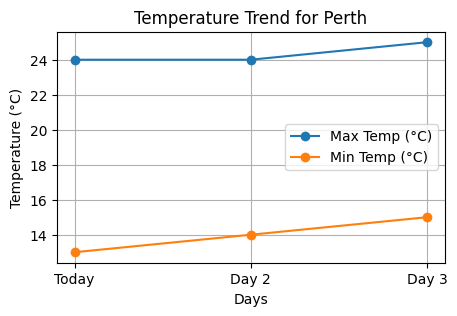

In [9]:
def create_weather_visualisation(weather_data: dict, city: str, attribute: str):
    """
    Generates a weather trend chart dynamically for the chosen attribute.
    Supports attributes: temperature, humidity, wind, description (skipped for plotting).
    """
    if "forecast_table" not in weather_data:
        print("No forecast data available to plot.")
        return

    # Extract forecast list again (not just the formatted table)
    forecast_data_list = weather_data.get("forecast_data_list", [])
    if not forecast_data_list:
        print("No valid forecast data available.")
        return

    # Prepare X-axis (days)
    days = ["Today"] + [f"Day {i}" for i in range(2, len(forecast_data_list)+1)]

    # Handle attribute-specific plotting
    if attribute == "temperature":
        max_vals = [day["maxtemp_celsius"] for day in forecast_data_list]
        min_vals = [day["mintemp_celsius"] for day in forecast_data_list]

        plt.figure(figsize=(5,3))
        plt.plot(days, max_vals, marker='o', label="Max Temp (°C)")
        plt.plot(days, min_vals, marker='o', label="Min Temp (°C)")
        plt.title(f"Temperature Trend for {city}")
        plt.xlabel("Days")
        plt.ylabel("Temperature (°C)")
        plt.legend()
        plt.grid(True)
        plt.show()

    elif attribute == "humidity":
        # Extract humidity from forecast (API has it per hour, we simplify by first hourly)
        humidity_vals = [day.get("humidity_percent", 50) for day in forecast_data_list]

        plt.figure(figsize=(5,3))
        plt.plot(days, humidity_vals, marker='o', color="blue", label="Humidity (%)")
        plt.title(f"Humidity Trend for {city}")
        plt.xlabel("Days")
        plt.ylabel("Humidity (%)")
        plt.legend()
        plt.grid(True)
        plt.show()

    elif attribute == "wind":
        wind_vals = [day.get("wind_speed_kmph", 10) for day in forecast_data_list]

        plt.figure(figsize=(5,3))
        plt.plot(days, wind_vals, marker='o', color="green", label="Wind Speed (km/h)")
        plt.title(f"Wind Speed Trend for {city}")
        plt.xlabel("Days")
        plt.ylabel("Wind Speed (km/h)")
        plt.legend()
        plt.grid(True)
        plt.show()

    else:
        print(f"⚠️ No visualisation available for attribute '{attribute}'. Showing only tables.")


# --- User Interaction ---
question = input("Ask about the weather (e.g., 'What is the humidity in London for the next 3 days?'):\n")

# Step 1: Parse user question
parsed_info = parse_weather_question_nlp(question)
city = parsed_info.get("location")
attribute = parsed_info.get("attributes")[0] if parsed_info.get("attributes") else "temperature"

if not city:
    print("❌ Could not determine city from your question. Please try again.")
else:
    # Step 2: Determine forecast days (default 3 if time not clear)
    forecast_days = 3
    q_lower = question.lower()
    if "5" in q_lower:
        forecast_days = 5
    elif "4" in q_lower:
        forecast_days = 4
    elif "3" in q_lower:
        forecast_days = 3
    elif "2" in q_lower:
        forecast_days = 2
    elif "tomorrow" in q_lower:
        forecast_days = 2

    # Step 3: Fetch weather
    weather_result = get_weather(city, forecast_days)

    if "error" in weather_result:
        print(weather_result["error"])
    else:
        # Show tables
        print("🌤 Current Weather in", city + ":")
        print(weather_result["current_weather_table"])
        print("\n📅 Forecast in", city + ":")
        print(weather_result["forecast_table"])

        # Step 4: Plot attribute trend
        create_weather_visualisation(weather_result, city, attribute)


# User Interface

# Main Application Logic

# Testing and Examples